In [229]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [233]:
file = '..\data\external\Legally_Operating_Businesses.csv'
df = pd.read_csv(file)
df = df[df['Latitude'].isna() == False]
df = df[df['Business Name'].isna()==False]
df = df[df['Address State']=='NY']
df['License Creation Date'] = pd.to_datetime(df['License Creation Date'], format = '%m/%d/%Y')
df['License Expiration Date'] = pd.to_datetime(df['License Expiration Date'], format = '%m/%d/%Y')
df['License Status'] = df['License Status']=='Active'
df['License Status'] = df['License Status'].astype('int')
drop_cols = ['DCA License Number', 'License Type', 'Business Name 2', 'Address Building', 'Address Street Name', 'Secondary Address Street Name', 'Address City', 'Address State', 'Address ZIP', 'Contact Phone Number', 'Address Borough','Borough Code','Community Board','Council District','BBL','NTA','Census Tract','Detail','Location']
df.drop(labels = drop_cols, axis=1, inplace = True)
df = df[df['Longitude'] > -76]
df.reset_index(drop = True, inplace = True)
df.head()

C:\Users\JackW\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,License Expiration Date,License Status,License Creation Date,Industry,Business Name,BIN,Longitude,Latitude
0,2022-06-30,1,2007-01-02,Electronic & Appliance Service,"DELTA ELECTRONICS, INC.",2073584.0,-73.835446,40.838469
1,2022-05-01,1,2018-10-31,Employment Agency,IDEAS EVENTS & BEYOND INC,4210471.0,-73.795002,40.710524
2,2022-06-30,1,2015-10-27,Electronic & Appliance Service,PHONE MATES INC,3013268.0,-74.010425,40.645018
3,2022-05-01,1,2012-07-13,Employment Agency,K-REG LLC,1032572.0,-73.969382,40.792751
4,2022-06-30,1,2012-01-10,Electronic & Appliance Service,NATWL COMPUTER CORP.,4141924.0,-73.825319,40.733833


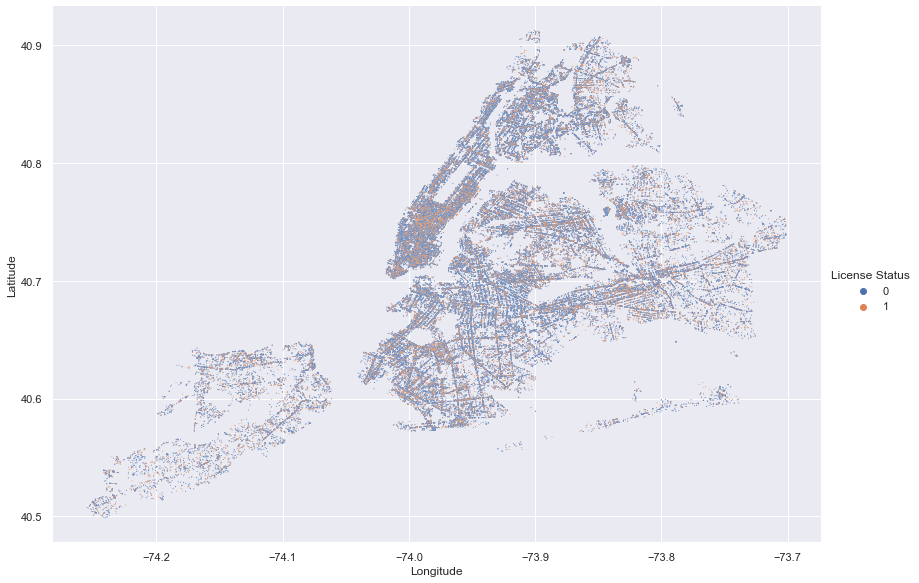

In [189]:
sns.relplot(x=df['Longitude'],y=df['Latitude'],s=1,hue=df['License Status'],height=8.27, aspect=11.7/8.27)

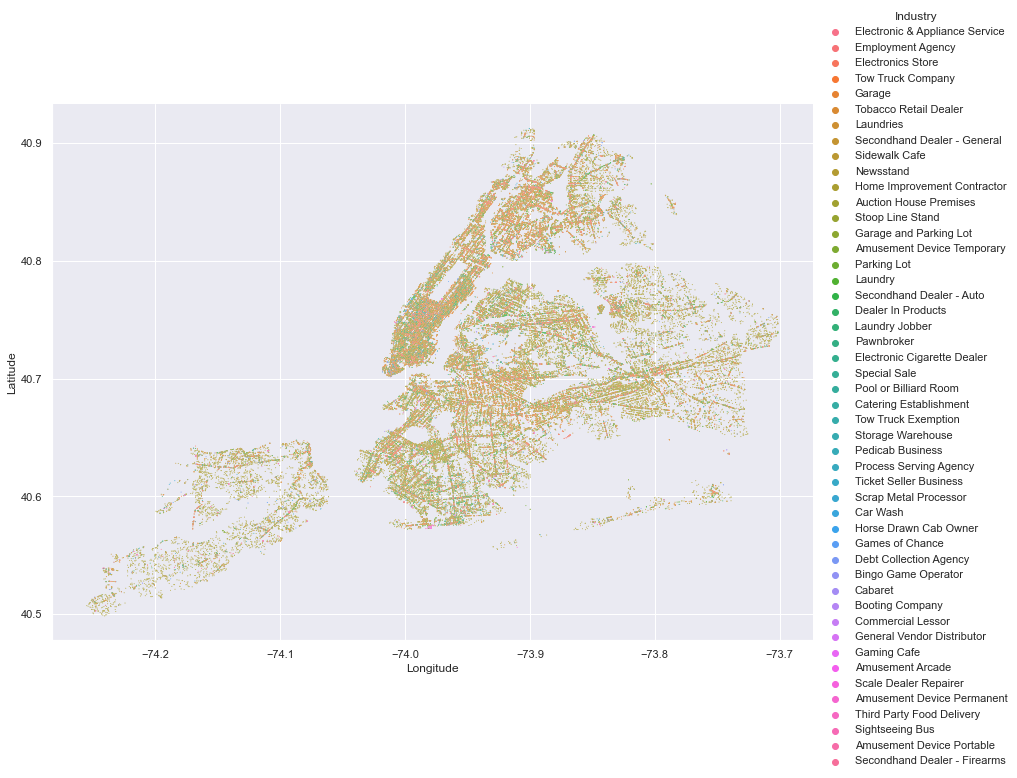

In [190]:
sns.relplot(x=df['Longitude'],y=df['Latitude'],s=1,hue=df['Industry'],height=8.27, aspect=11.7/8.27)

<AxesSubplot:>

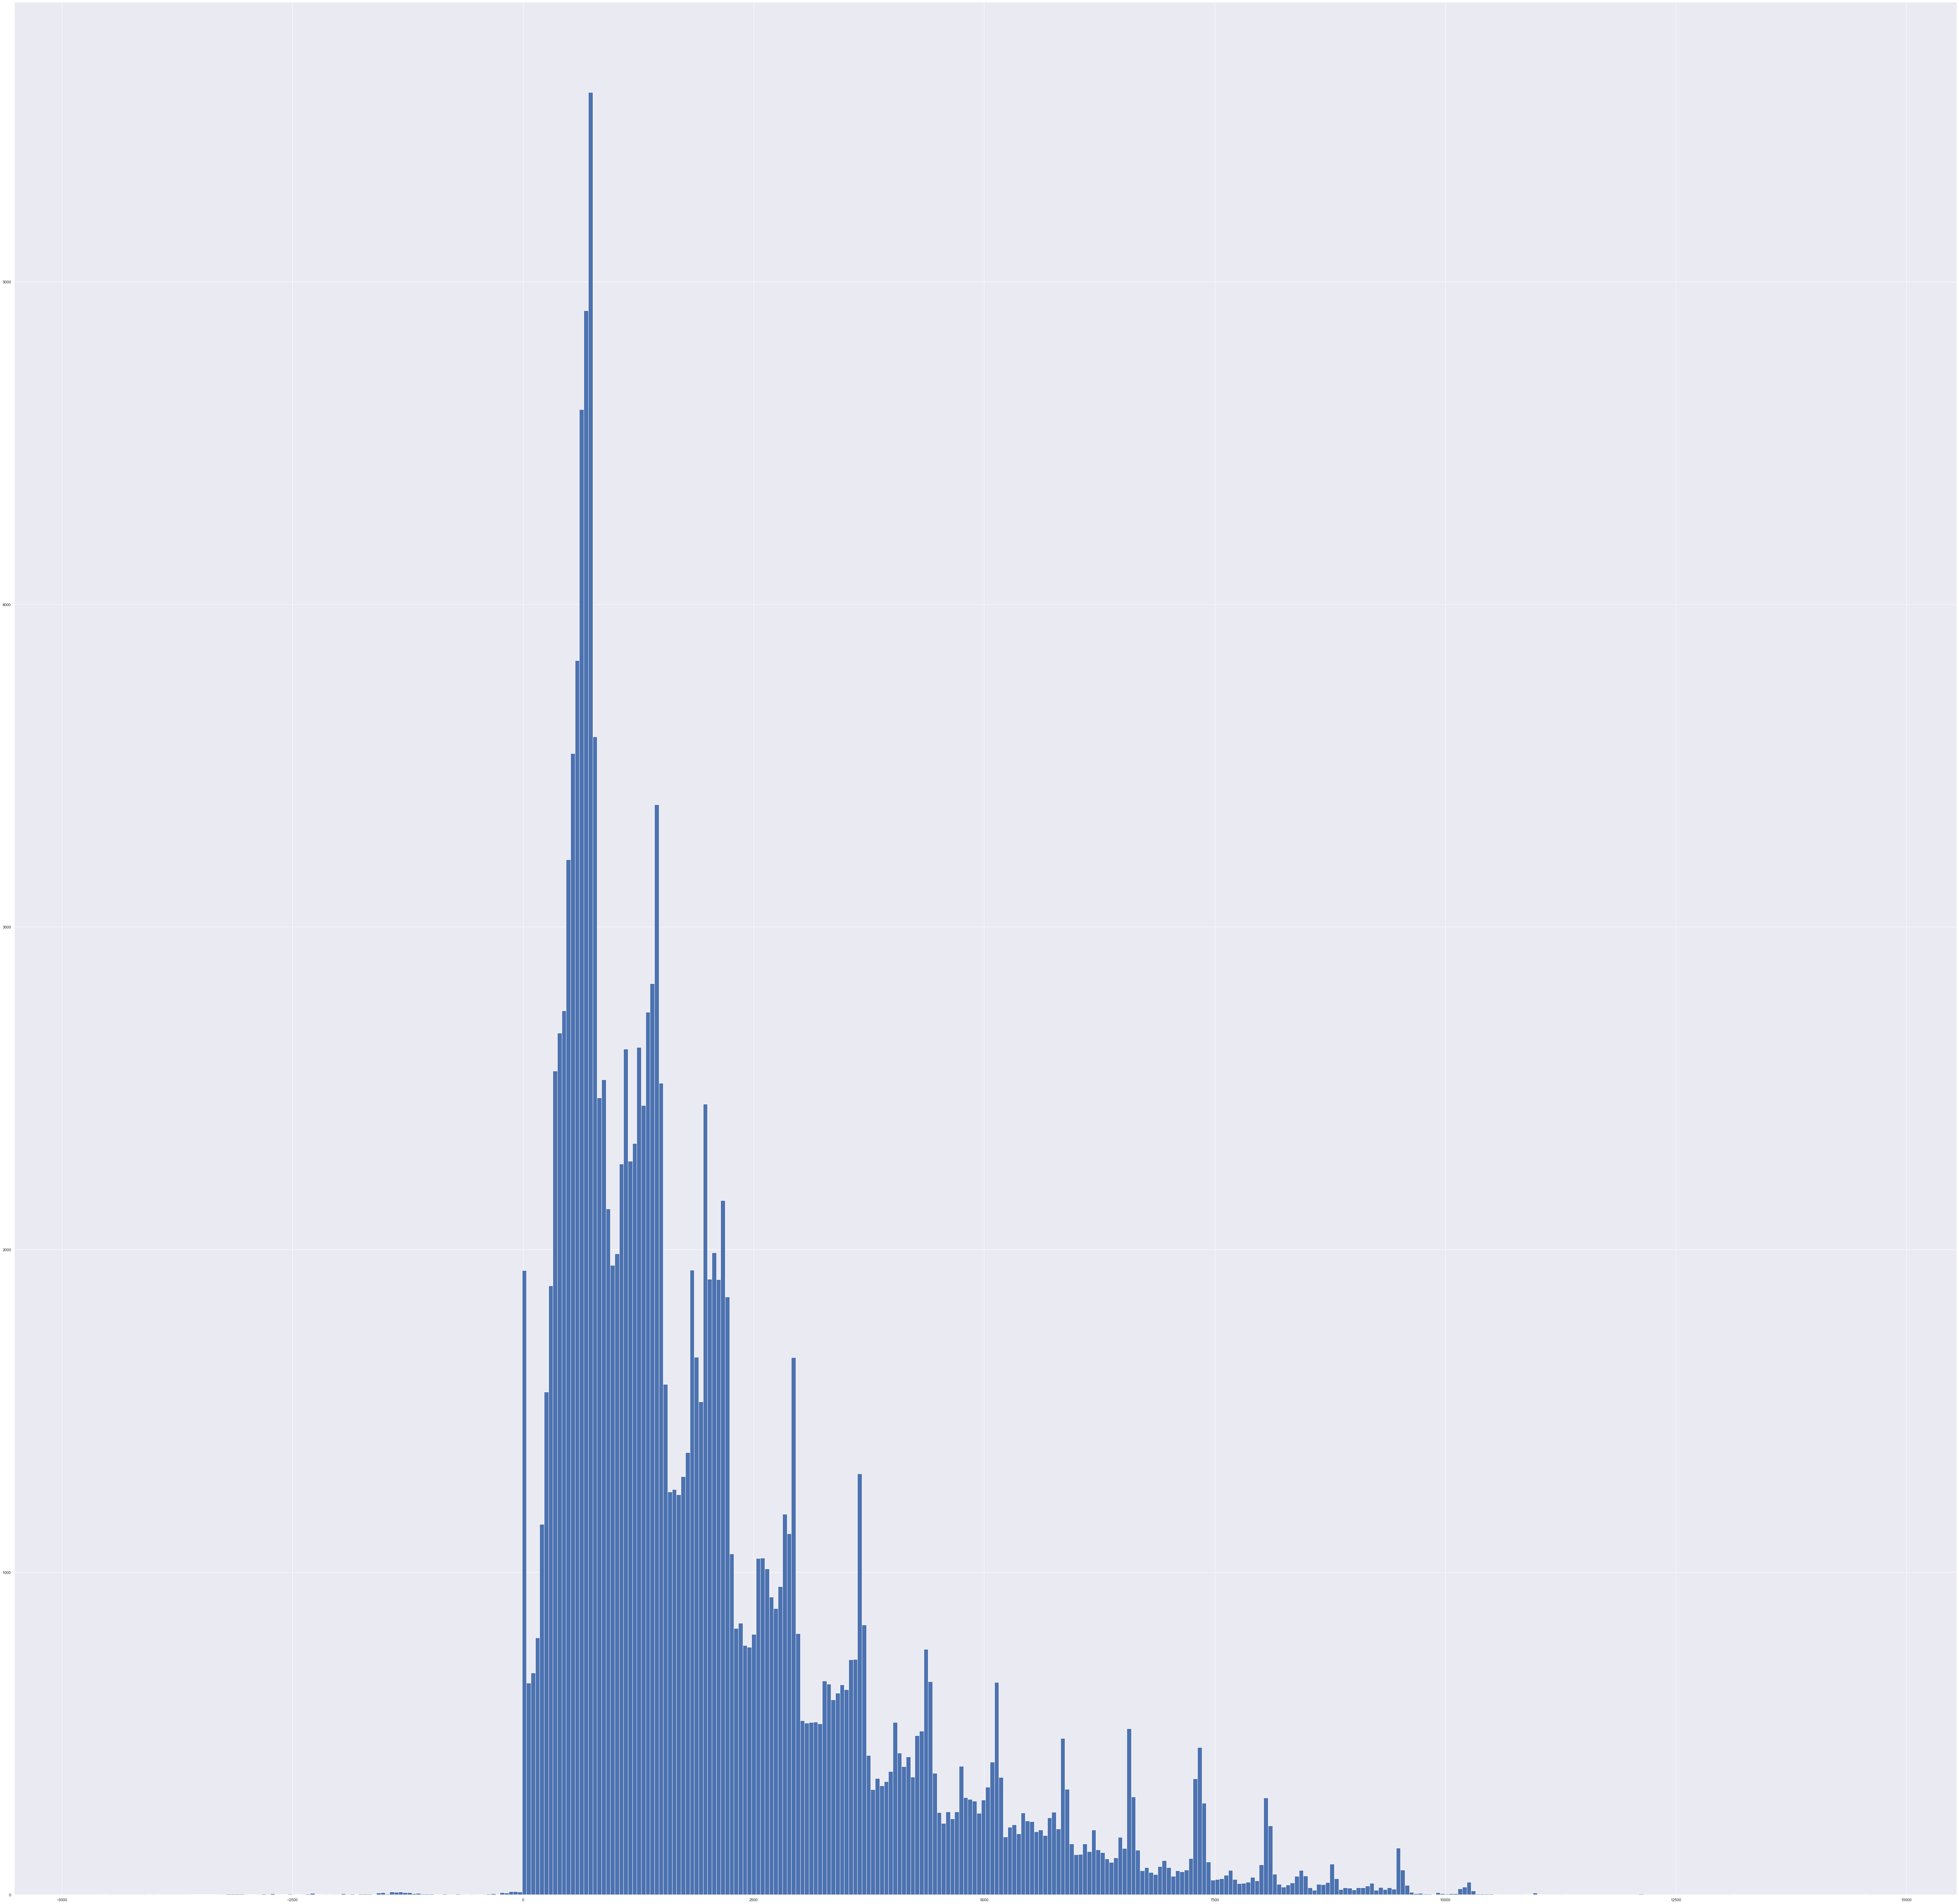

In [235]:
# How is the difference between creation and expiration date distributed?
#There are spikes at around each 1 year mark.
df['date_diffs']=(df['License Expiration Date']-df['License Creation Date']).dt.days
df['date_diffs'].hist(bins=400)

In [250]:
# Around 200 entries have impossible creation/expiration dates, all but 1 of these are listed as 'expired'

df=df[df['date_diffs']>0]

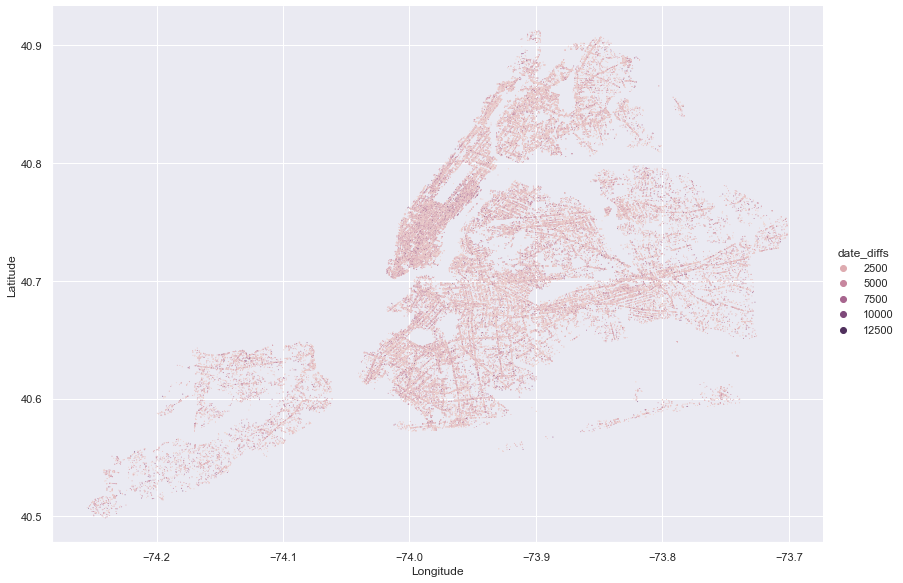

In [194]:
sns.relplot(x=df['Longitude'],y=df['Latitude'],s=1,hue=df['date_diffs'],height=8.27, aspect=11.7/8.27)

<AxesSubplot:xlabel='date_diffs', ylabel='Industry'>

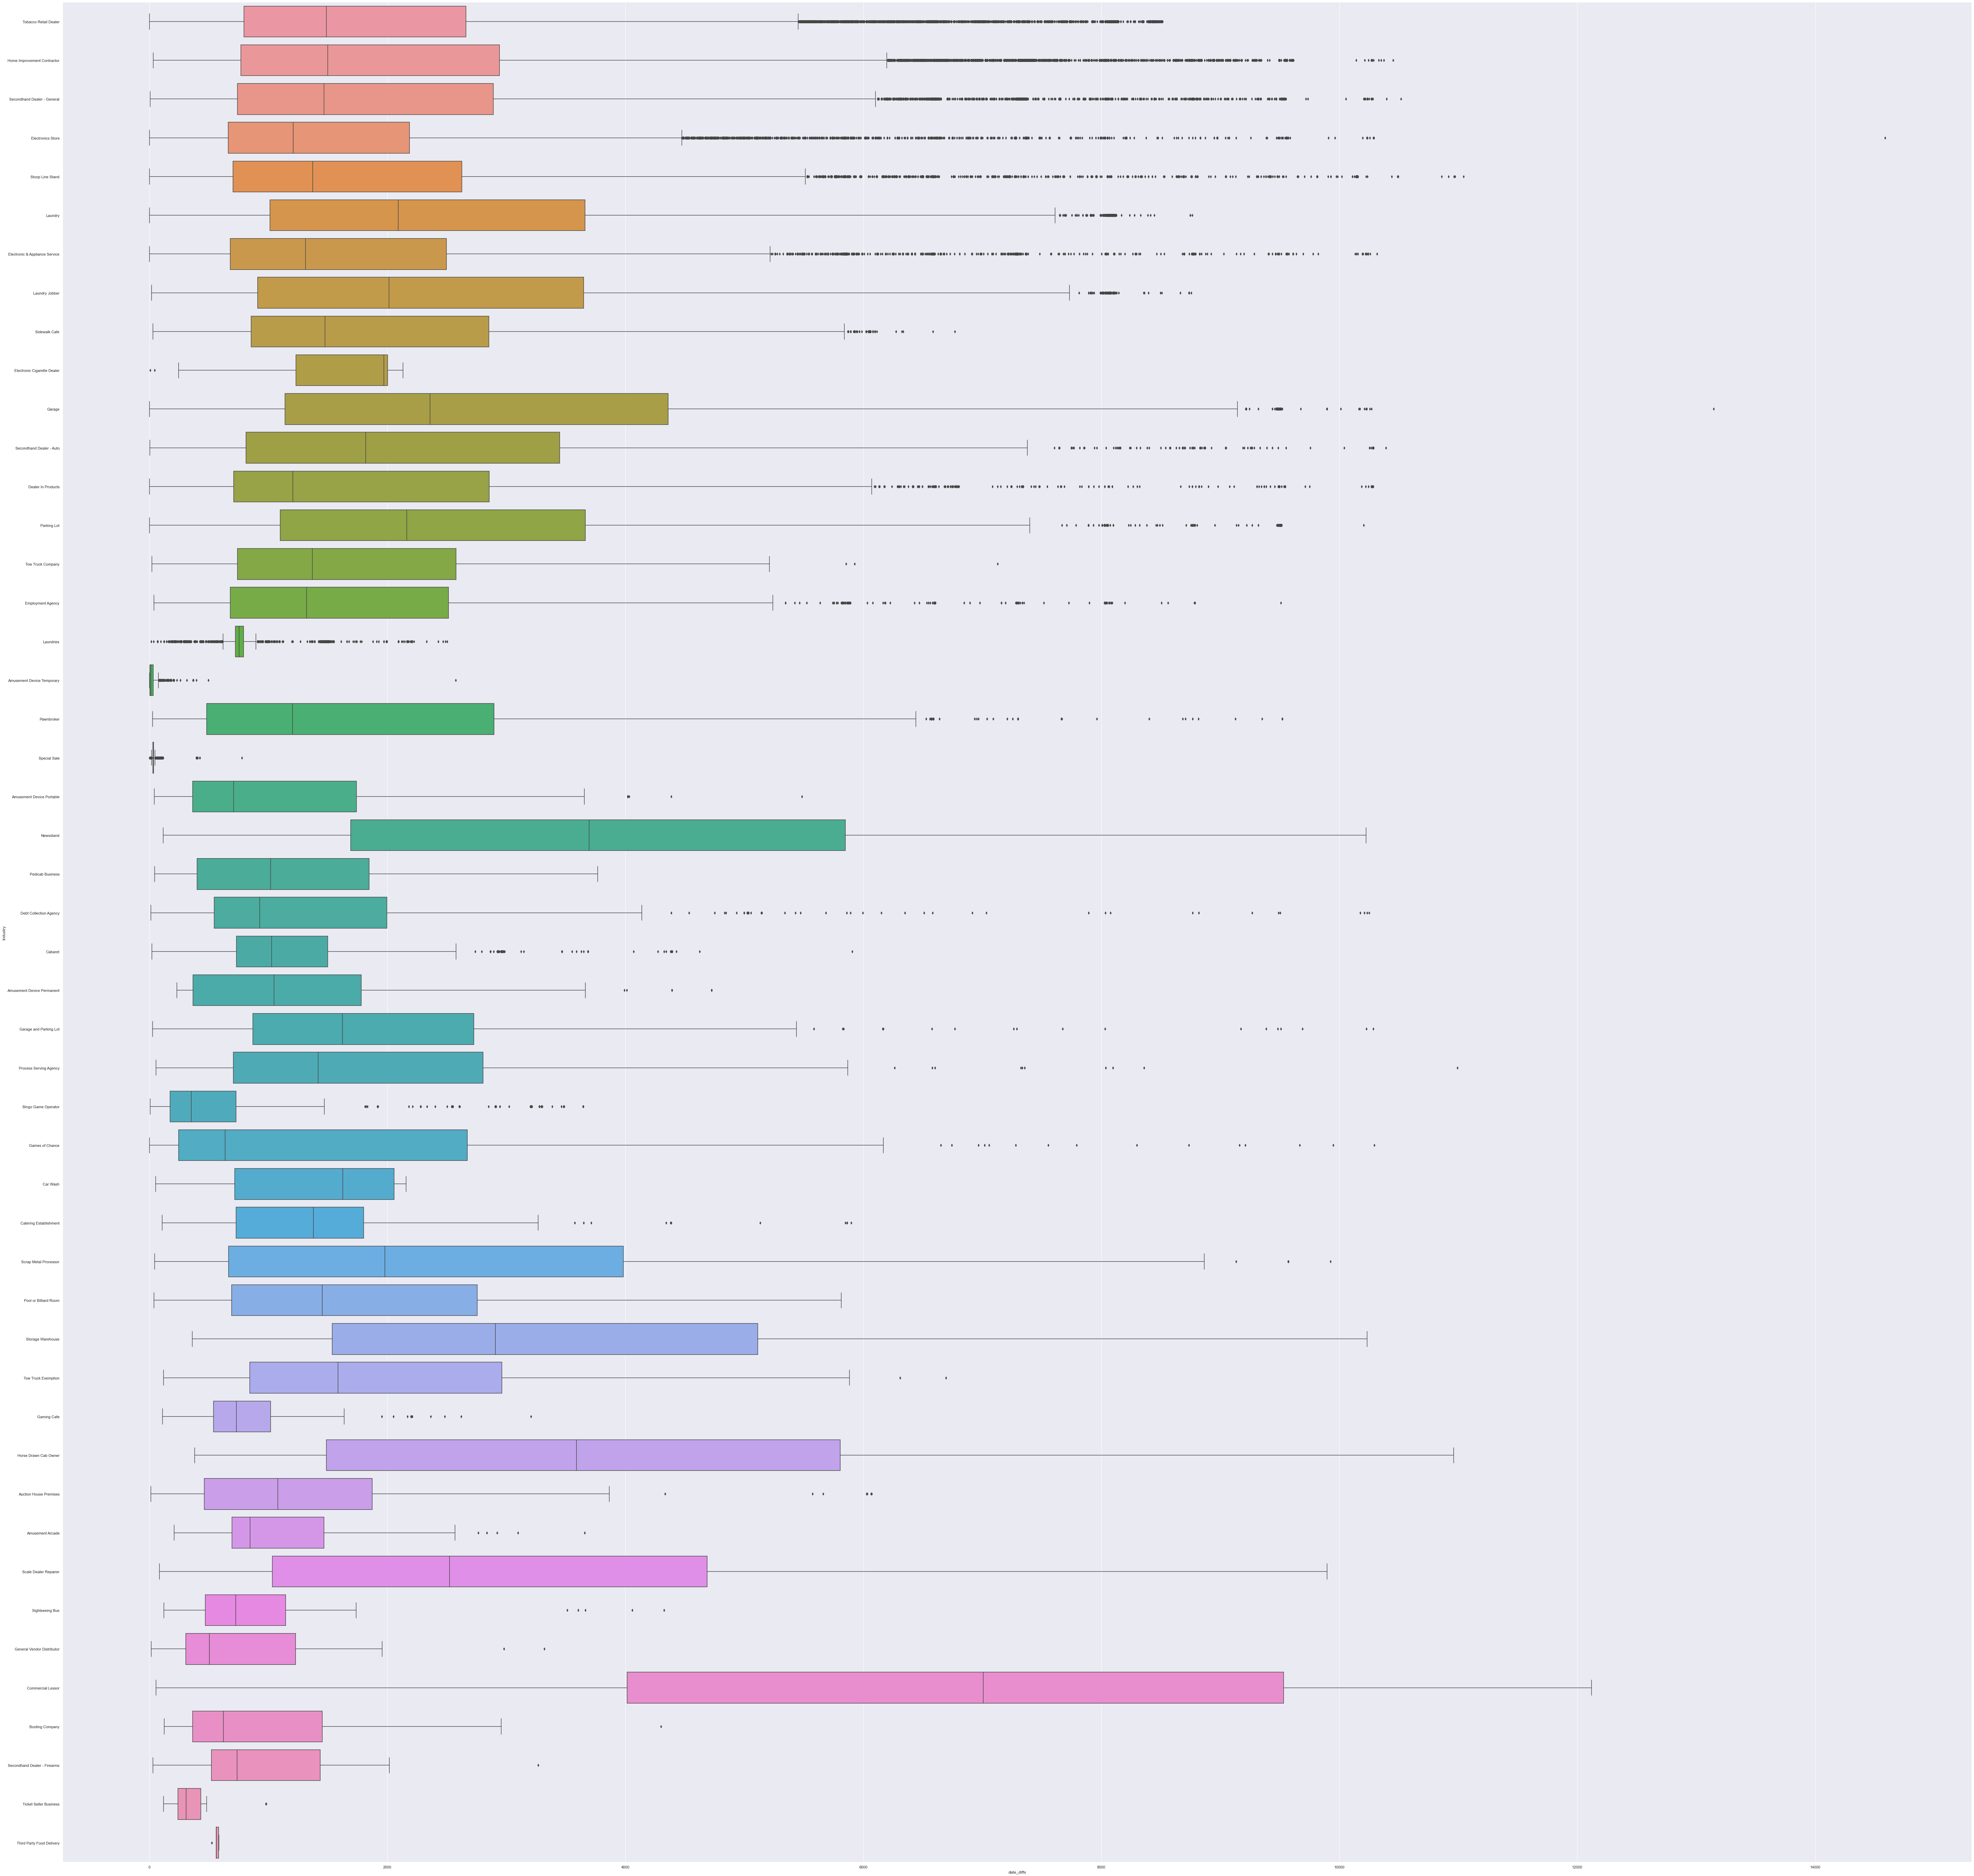

In [195]:
# Create boxplots for the duration of the license, ordered by the most popular licenses. The most common licenses have a 
# relatively comparable distribution, at least compared to the outliers.

index=df.groupby('Industry')['date_diffs'].count().sort_values(ascending=False).index
sns.boxplot(y="Industry", x="date_diffs", data=df,orient="h",order=index)

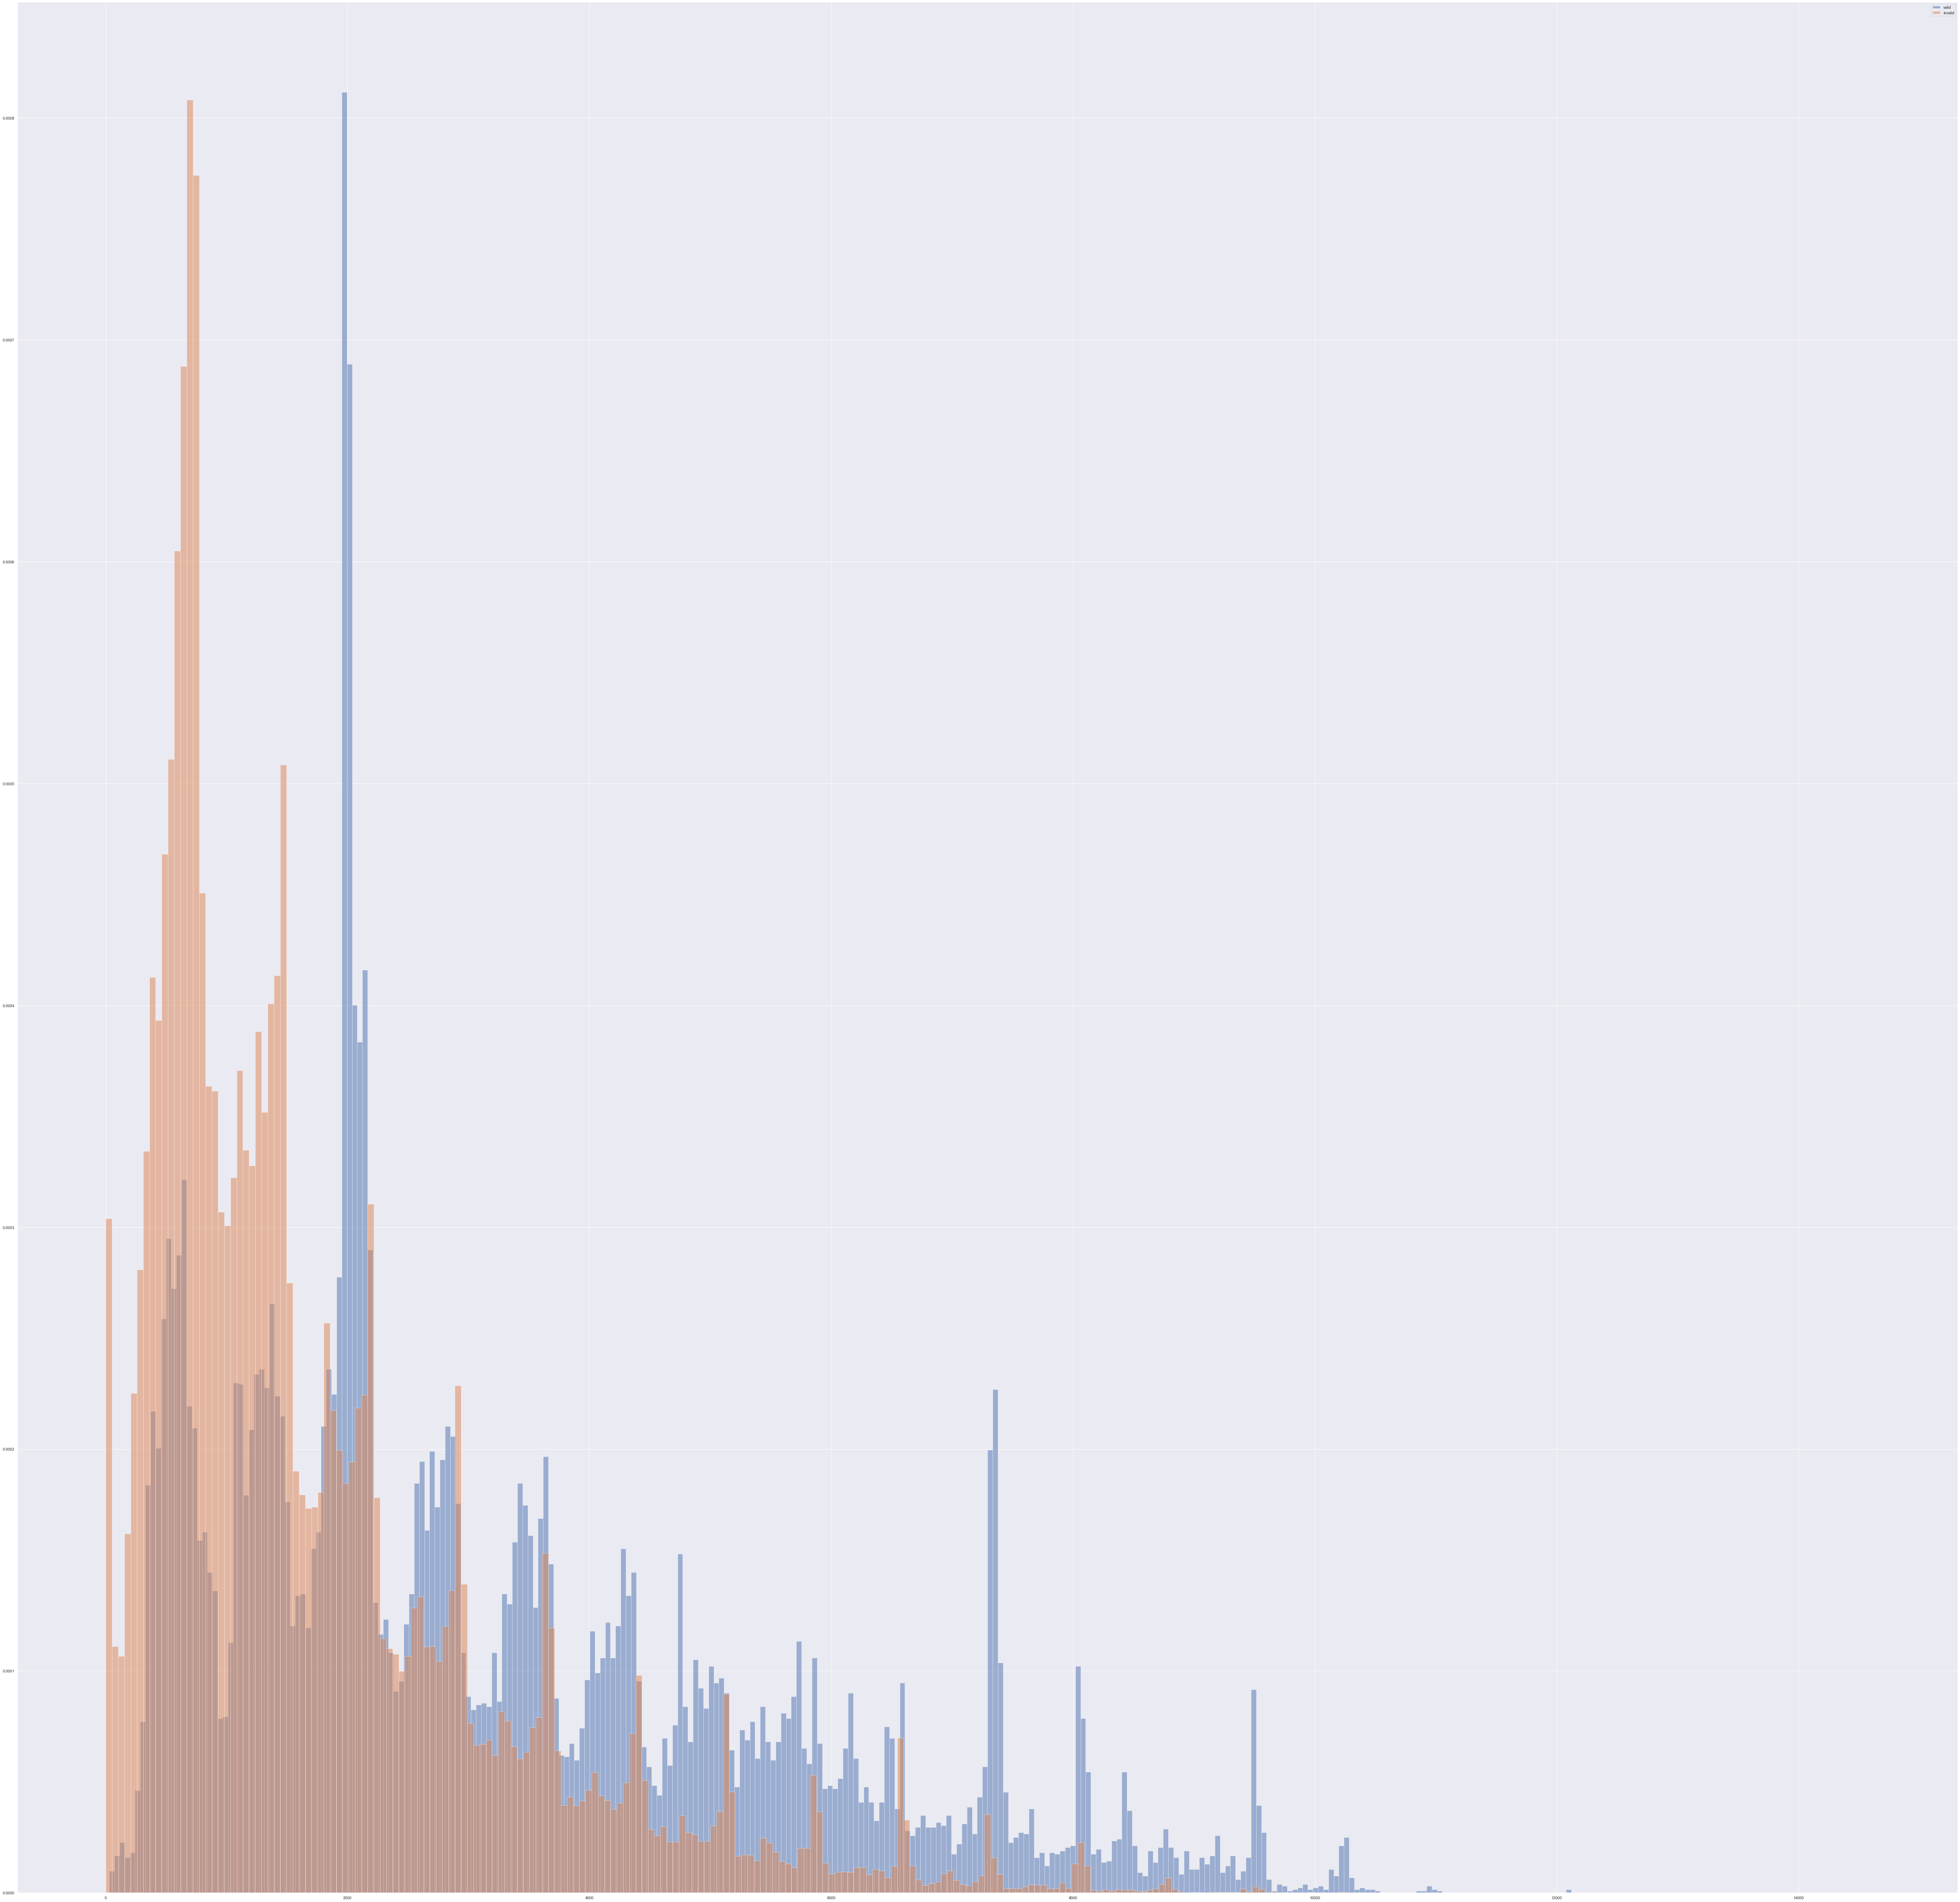

In [207]:
plt.hist(df[df['License Status']==1]['date_diffs'], 283, alpha=0.5, label='valid', density=True)
plt.hist(df[df['License Status']==0]['date_diffs'], 283, alpha=0.5, label='invalid', density=True)
plt.legend(loc='upper right')
plt.show()

In [228]:
print(df[df['License Status']==1]['date_diffs'].mean())
print(df[df['License Status']==0]['date_diffs'].mean())

# Is the difference between them significant?
stats.ttest_ind(df[df['License Status']==0]['date_diffs'],df[df['License Status']==1]['date_diffs'])

3217.528064109607
1744.7906696382543


Ttest_indResult(statistic=-138.1672315199151, pvalue=0.0)

In [227]:
# We can double check that the differences between industries are statistically significant
print('mean:',df[df['Industry']=='Tobacco Retail Dealer']['date_diffs'].mean(),'std:',df[df['Industry']=='Tobacco Retail Dealer']['date_diffs'].std())
print('Uncertainty in the average:', df[df['Industry']=='Tobacco Retail Dealer']['date_diffs'].std() / len(df[df['Industry']=='Tobacco Retail Dealer']['date_diffs']))

stats.ttest_ind(df[df['Industry']=='Tobacco Retail Dealer']['date_diffs'],df[df['Industry']=='Home Improvement Contractor']['date_diffs'])

mean: 2022.6253779585027 std: 1604.9317581385635
uncertainty in the average: 0.04183431754088634


Ttest_indResult(statistic=-10.31148640941959, pvalue=6.519372508530571e-25)